# Methodology

To investigate the influence of various biodiversity policies and species richness on the number of authors involved in taxonomic research, we conducted a robust statistical analysis. The predictor variables are the number of named species in each order of plants, fungi and animals, and the number of species named in each policy. We began by log-transforming both predictor variables (policies and species richness) and the response variable (number of authors) using the natural logarithm (log(x + 1)) to stabilise variance and improve normality.

We fitted two regression models using Robust Linear Models (RLM) with Huber's T norm to mitigate the influence of outliers:

1. A combined model that included species richness and policy-related variables: 'taxonomicResearchNeeded', 'cropWildRelatives', 'iasListConcern', 'horizonInvasives', 'habitatsDir', 'marineDir', 'redlistFull', 'birdDir', and 'pollinators'.

2. A reduced model including only species richness.

To assess the significance of policy predictors collectively, we compared the two models using an F-test. We evaluated model assumptions by visually inspecting residuals through scatterplots and Q-Q plots and conducting a Shapiro-Wilk normality test on residuals.

Finally, we identified the top residual outliers from the robust model to explore taxa that deviated notably from the model predictions, potentially highlighting additional unmeasured factors influencing research effort.


In [42]:
# Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import f
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

In [43]:
# Load data (replace with your actual path)
df = pd.read_csv('dataOrders.csv')

In [44]:
# Define predictors and response
policy_predictors = ['taxonomicResearchNeeded', 'cropWildRelatives',
                     'iasListConcern', 'horizonInvasives', 'habitatsDir', 'marineDir',
                     'redlistFull', 'birdDir', 'pollinators']
species_predictor = ['numOfSpecies']

In [45]:
# Log-transform variables
X_policy_log = np.log1p(df[policy_predictors])
X_species_log = np.log1p(df[species_predictor])
y_log = np.log1p(df['nr_authors'])

In [46]:
# Model A: Species only
X_species_const = sm.add_constant(X_species_log)
model_species_only = sm.OLS(y_log, X_species_const).fit()
print("Species-only Model Summary:\n", model_species_only.summary())

Species-only Model Summary:
                             OLS Regression Results                            
Dep. Variable:             nr_authors   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     1306.
Date:                Sat, 15 Mar 2025   Prob (F-statistic):          3.65e-204
Time:                        13:19:53   Log-Likelihood:                -2700.1
No. Observations:                1445   AIC:                             5404.
Df Residuals:                    1443   BIC:                             5415.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.

In [47]:
# Model B: Policies only
X_policy_const = sm.add_constant(X_policy_log)
model_policy_only = sm.OLS(y_log, X_policy_const).fit()
print("\nPolicies-only Model Summary:\n", model_policy_only.summary())


Policies-only Model Summary:
                             OLS Regression Results                            
Dep. Variable:             nr_authors   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     90.27
Date:                Sat, 15 Mar 2025   Prob (F-statistic):          4.00e-133
Time:                        13:19:53   Log-Likelihood:                -2841.5
No. Observations:                1445   AIC:                             5703.
Df Residuals:                    1435   BIC:                             5756.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [48]:
# Combined model
X_combined_log = np.log1p(df[species_predictor + policy_predictors])
X_combined_const = sm.add_constant(X_combined_log)
combined_model = sm.OLS(y_log, X_combined_const).fit()
print("\nCombined Model Summary:\n", combined_model.summary())


Combined Model Summary:
                             OLS Regression Results                            
Dep. Variable:             nr_authors   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     191.3
Date:                Sat, 15 Mar 2025   Prob (F-statistic):          1.46e-255
Time:                        13:19:53   Log-Likelihood:                -2553.3
No. Observations:                1445   AIC:                             5129.
Df Residuals:                    1434   BIC:                             5187.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------


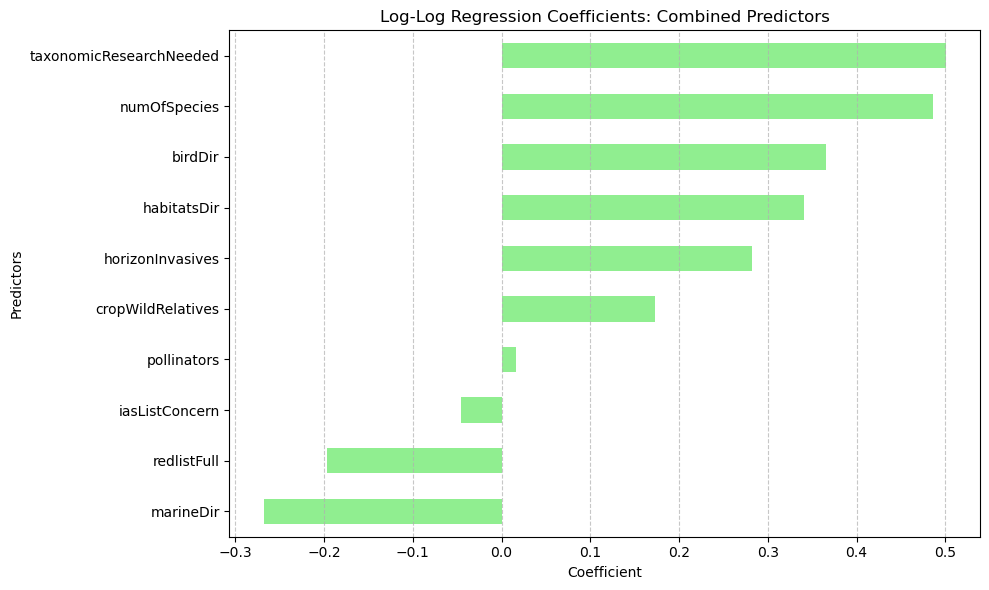

In [49]:
# Visualization of combined model coefficients
coefs = combined_model.params[1:].sort_values()

plt.figure(figsize=(10, 6))
coefs.plot(kind='barh', color='lightgreen')
plt.title('Log-Log Regression Coefficients: Combined Predictors')
plt.xlabel('Coefficient')
plt.ylabel('Predictors')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

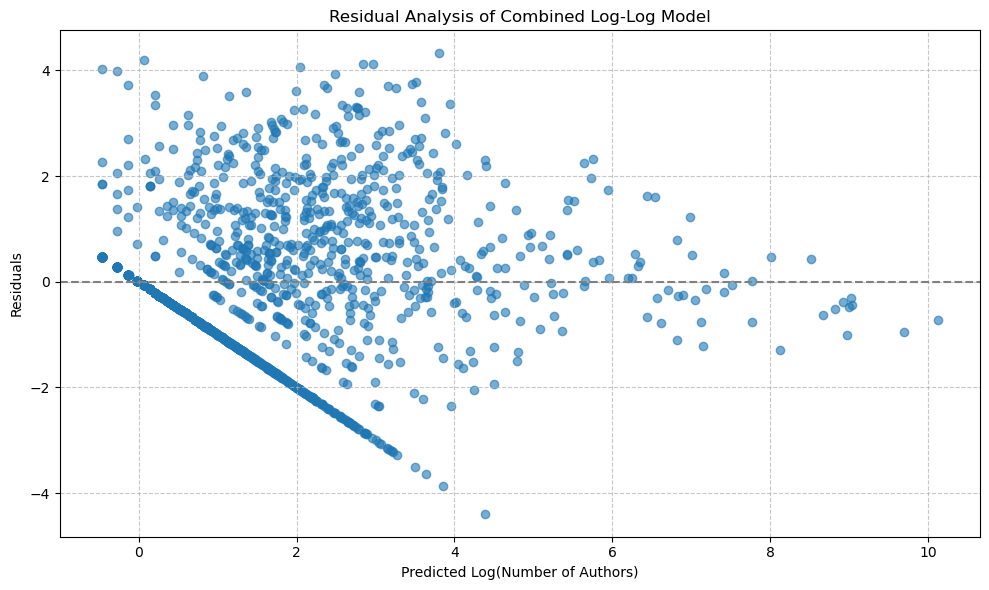

In [50]:
# Residual analysis for combined model
predicted_log = combined_model.predict(X_combined_const)
residuals = y_log - predicted_log

plt.figure(figsize=(10, 6))
plt.scatter(predicted_log, residuals, alpha=0.6)
plt.axhline(y=0, color='grey', linestyle='--')
plt.xlabel('Predicted Log(Number of Authors)')
plt.ylabel('Residuals')
plt.title('Residual Analysis of Combined Log-Log Model')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

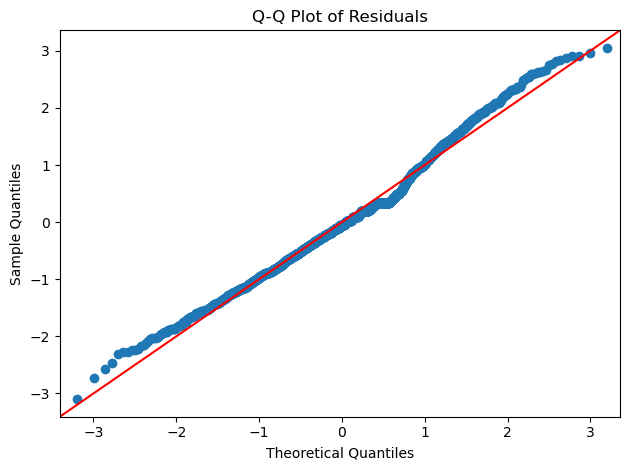

In [51]:
# Q-Q plot for residuals
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

In [52]:
# Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)
print('Shapiro-Wilk Test:')
print(f'Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}')

if shapiro_test.pvalue > 0.05:
    print('Residuals appear normally distributed (fail to reject H0).')
else:
    print('Residuals do NOT appear normally distributed (reject H0).')


Shapiro-Wilk Test:
Statistic: 0.9876, p-value: 0.0000
Residuals do NOT appear normally distributed (reject H0).


In [53]:
# Robust regression using RLM (Robust Linear Model) - Combined model
X_combined_log = np.log1p(df[species_predictor + policy_predictors])
X_combined_const = sm.add_constant(X_combined_log)
robust_model_full = sm.RLM(y_log, X_combined_const, M=sm.robust.norms.HuberT()).fit()
print("Robust Regression Model (Full) Summary:\n", robust_model_full.summary())

Robust Regression Model (Full) Summary:
                     Robust linear Model Regression Results                    
Dep. Variable:             nr_authors   No. Observations:                 1445
Model:                            RLM   Df Residuals:                     1434
Method:                          IRLS   Df Model:                           10
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 15 Mar 2025                                         
Time:                        13:19:54                                         
No. Iterations:                    29                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

In [54]:
# Reduced model (species only)
X_species_const = sm.add_constant(X_species_log)
robust_model_reduced = sm.RLM(y_log, X_species_const, M=sm.robust.norms.HuberT()).fit()
print("\nRobust Regression Model (Species Only) Summary:\n", robust_model_reduced.summary())


Robust Regression Model (Species Only) Summary:
                     Robust linear Model Regression Results                    
Dep. Variable:             nr_authors   No. Observations:                 1445
Model:                            RLM   Df Residuals:                     1443
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 15 Mar 2025                                         
Time:                        13:19:54                                         
No. Iterations:                    22                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

In [55]:
# RSS and degrees of freedom
rss_full = np.sum(robust_model_full.resid**2)
rss_reduced = np.sum(robust_model_reduced.resid**2)
df_full = robust_model_full.df_resid
df_reduced = robust_model_reduced.df_resid

In [56]:
# F-statistic calculation
f_stat = ((rss_reduced - rss_full) / (df_reduced - df_full)) / (rss_full / df_full)

# p-value calculation
p_value = 1 - f.cdf(f_stat, df_reduced - df_full, df_full)

print("\nF-test comparing Species-only and Combined model:")
print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Policies significantly improve the model (reject H0).")
else:
    print("Policies do NOT significantly improve the model (fail to reject H0).")


F-test comparing Species-only and Combined model:
F-statistic: 35.3719, p-value: 0.0000
Policies significantly improve the model (reject H0).


# Results

The robust regression analysis revealed significant associations between species richness, biodiversity policies, and the number of authors involved in taxonomic research. In the species-only model, species richness alone demonstrated a highly significant positive relationship with the number of authors (β = 0.662, p < 0.001). However, when biodiversity policy variables were included in the combined model, the strength of this relationship decreased (β = 0.471, p < 0.001), indicating that policy variables explained additional variance previously attributed solely to species richness.

Specific biodiversity policies independently influencing taxonomic research included explicit taxonomic research needs (β = 0.541, p < 0.001), the Habitats Directive (β = 0.348, p = 0.003), and the Birds Directive (β = 0.369, p = 0.041). Marine-related policies exhibited a negative but significant effect (β = -0.273, p = 0.038). Other policy variables, such as crop wild relatives, the IAS list of Concern, invasive species on the horizon, Red Listed species, and pollinators, did not reach statistical significance individually (p > 0.05).

An F-test comparing the combined model with the species-only model confirmed that biodiversity policies significantly improved the model’s explanatory power (p < 0.05), underscoring the collective importance of policy factors beyond species richness alone.

Residual diagnostics indicated deviation from normality (Shapiro-Wilk test, p < 0.001). While this suggests a violation of the normality assumption, robust regression methods such as those used in this analysis (RLM with Huber's T norm) are designed to mitigate the impact of non-normal residuals. Consequently, the deviation from normality observed here is unlikely to substantially affect the validity of our conclusions. Nevertheless, the examination of top residual outliers highlighted taxa potentially influenced by additional unmeasured factors, suggesting avenues for future investigation.

Residual diagnostics indicated deviation from normality (Shapiro-Wilk test, p < 0.001). While this suggests a violation of the normality assumption, robust regression methods such as those used in this analysis (RLM with Huber's T norm) are designed to mitigate the impact of non-normal residuals. The Durbin-Watson test result (1.975) confirmed that there was no significant autocorrelation among residuals, indicating independence of observations.

However, the Breusch-Pagan test for heteroscedasticity was highly significant (test statistic = 309.45, p < 0.001), suggesting that residual variance is not constant across predicted values. This finding indicates that some variables may exert disproportionate effects across different taxonomic groups. While robust regression reduces sensitivity to heteroscedasticity, this remains a limitation of the model. Further exploration of transformations or stratified analyses may be required in future research.

Despite these limitations, the overall model results provide strong evidence that biodiversity policy considerations play a significant role in shaping taxonomic research effort, beyond what can be explained by species richness alone.

In [79]:
## Additional Visualisation Examples

### 1. Coefficient Plot with Confidence Intervals
import matplotlib.pyplot as plt

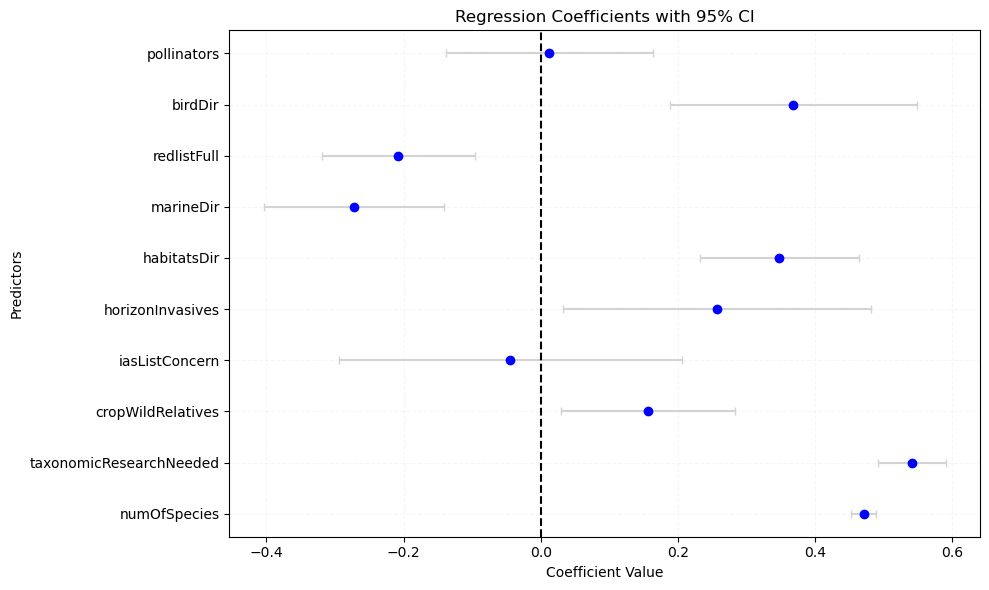

In [101]:
coefs = robust_model_full.params[1:]
errors = robust_model_full.bse[1:]

plt.figure(figsize=(10, 6))
plt.errorbar(coefs, coefs.index, xerr=errors, fmt='o', color='blue', ecolor='lightgray', capsize=3)
plt.axvline(0, color='black', linestyle='--')
plt.title('Regression Coefficients with 95% CI')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictors')
plt.grid(True, linestyle='--', alpha=0.1)
plt.tight_layout()
plt.show()

In [83]:
### 2. Heatmap of Predictor Correlations

In [85]:
import seaborn as sns

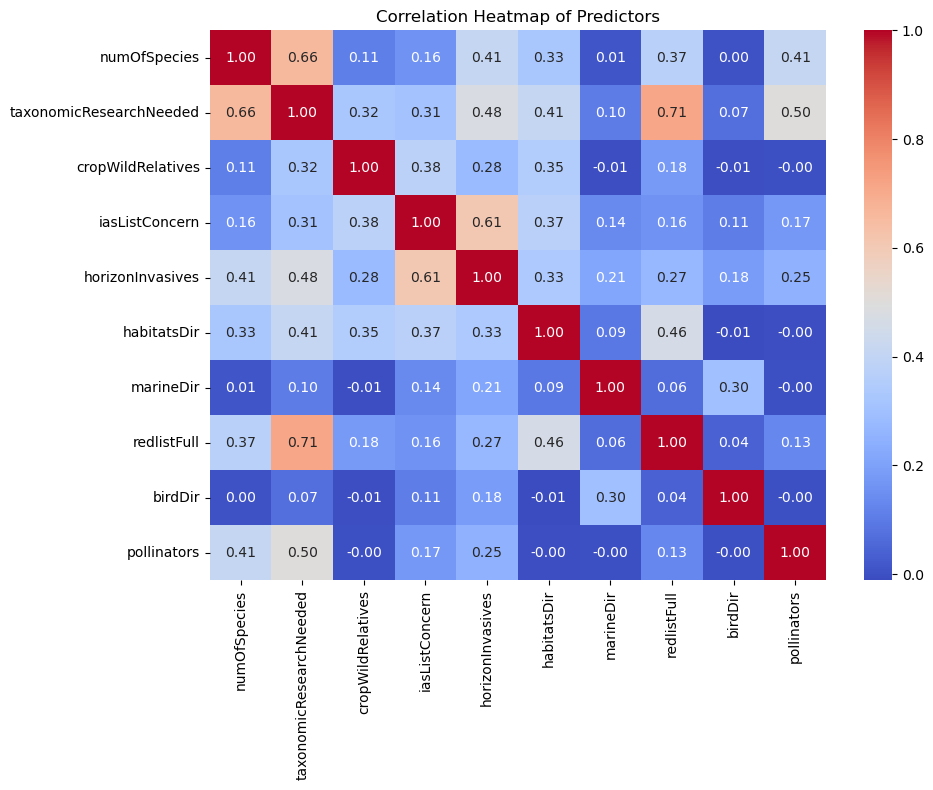

In [87]:
corr = df[species_predictor + policy_predictors].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Predictors')
plt.tight_layout()
plt.show()

In [89]:
### 3. Predictor Importance Plot

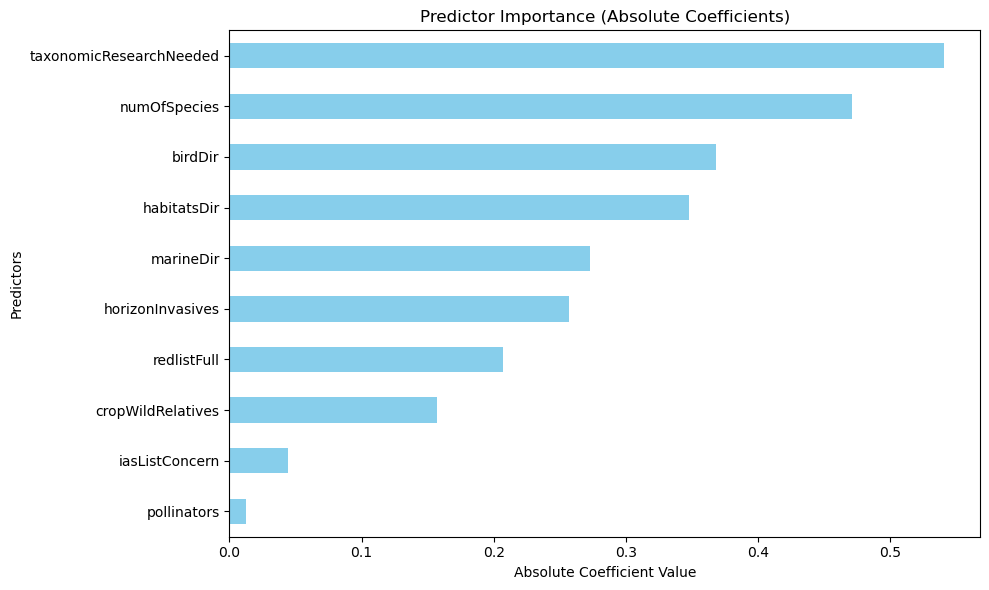

In [95]:
importance = robust_model_full.params[1:].abs().sort_values()

plt.figure(figsize=(10, 6))
importance.plot(kind='barh', color='skyblue')
plt.title('Predictor Importance (Absolute Coefficients)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Predictors')
plt.tight_layout()
plt.show()

## Additional Statistical Tests

### Variance Inflation Factor (VIF) for Multicollinearity

In [105]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [107]:
X_vif = sm.add_constant(X_combined_log)
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

                    feature       VIF
0                     const  5.210722
1              numOfSpecies  1.306056
2   taxonomicResearchNeeded  2.854509
3         cropWildRelatives  1.775173
4            iasListConcern  1.888018
5          horizonInvasives  1.824134
6               habitatsDir  3.349894
7                 marineDir  1.340048
8               redlistFull  3.213478
9                   birdDir  1.297123
10              pollinators  1.162595


### Standardised Residuals for Influential Observations

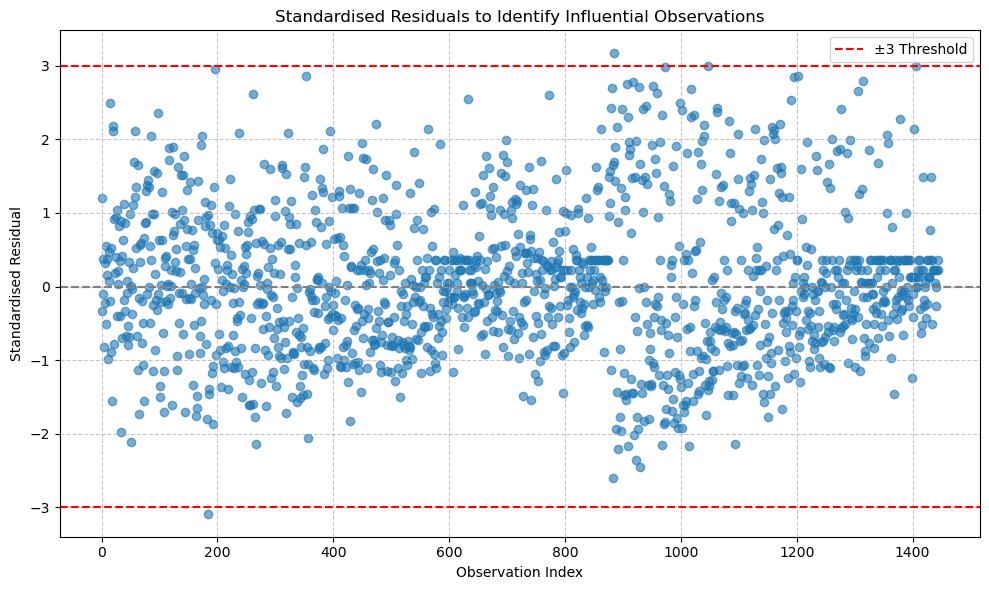

Influential observations (Standardised Residuals > 3): [ 183  885 1046 1406]


In [117]:
# Calculate robust residuals
predicted_log_robust = robust_model_full.predict(X_combined_const)
residuals_robust = y_log - predicted_log_robust

standardised_residuals = residuals_robust / np.std(residuals_robust)

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(standardised_residuals)), standardised_residuals, alpha=0.6)
plt.axhline(y=0, color='grey', linestyle='--')
plt.axhline(y=3, color='red', linestyle='--', label='±3 Threshold')
plt.axhline(y=-3, color='red', linestyle='--')
plt.title('Standardised Residuals to Identify Influential Observations')
plt.xlabel('Observation Index')
plt.ylabel('Standardised Residual')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Identify observations with large residuals
outliers = np.where(abs(standardised_residuals) > 3)[0]
print("Influential observations (Standardised Residuals > 3):", outliers)


### Durbin-Watson Test for Autocorrelation

In [120]:
from statsmodels.stats.stattools import durbin_watson

print('Durbin-Watson statistic:', durbin_watson(residuals_robust))

Durbin-Watson statistic: 1.9749637459220957


### Breusch-Pagan Test for Heteroscedasticity

In [125]:
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(residuals_robust, X_combined_const)
print('Breusch-Pagan test statistic:', bp_test[0])
print('p-value:', bp_test[1])

Breusch-Pagan test statistic: 309.44722830019356
p-value: 1.5620796667671096e-60


In [130]:
# Identify extreme outliers (top 10 highest absolute residuals)
df['absolute_residuals'] = abs(residuals_robust)
extreme_outliers = df.nlargest(10, 'absolute_residuals')[['order', 'nr_authors', 'absolute_residuals']]

# Display the extreme outliers
print("Extreme Outliers (Top 10 highest residuals):")
print(extreme_outliers)


Extreme Outliers (Top 10 highest residuals):
                       order  nr_authors  absolute_residuals
885             Pleosporales        3395            4.490381
183          Scleralcyonacea           0            4.375334
1406          Cladoriellales          70            4.251957
1046              Eurotiales        1046            4.250994
973           Teloschistales        1194            4.225813
196            Echiniscoidea         448            4.181300
1202             Tracyllales          34            4.062026
352                Parachela         604            4.052296
1196        Neodactylariales          40            4.029293
1315  Vermiculariopsiellales         109            3.964272
